In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import glob
from pathlib import Path
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgbm

(60001, 10)
   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0     -94.0     550.0     -41.0    -444.0      31.0     191.0    -169.0   
1     -64.0     520.0     -21.0    -498.0      55.0     212.0     -68.0   
2     -30.0     425.0     -53.0    -499.0      86.0     -75.0     115.0   
3      -3.0     289.0     -44.0    -566.0      93.0    -184.0     244.0   
4      -6.0     138.0      -7.0    -682.0     100.0     -77.0     280.0   

   sensor_8  sensor_9  sensor_10  
0    -118.0      -1.0      374.0  
1     249.0     -48.0      396.0  
2     229.0     -66.0      465.0  
3     495.0     -13.0      514.0  
4     310.0      75.0      494.0  


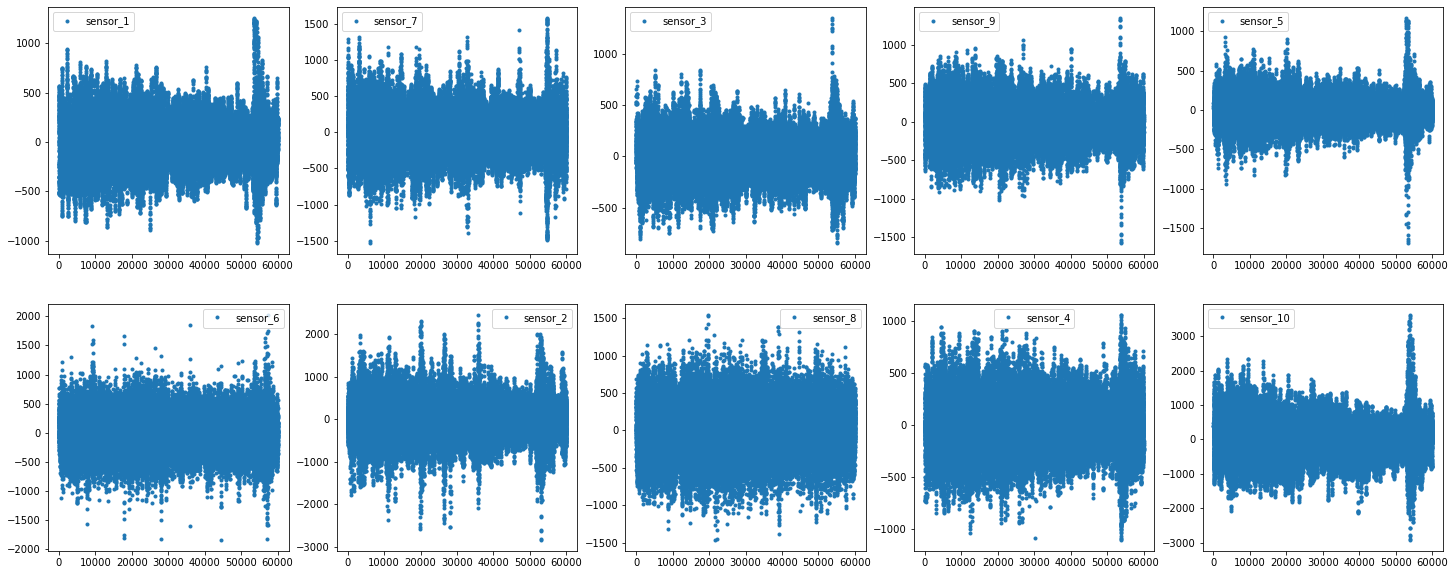

In [30]:
signals_n=10
df=pd.read_csv("train/2068207140.csv")
print(df.shape)
print(df.head())
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

for i, sensor_num in enumerate(df):
    sensor_data = np.nan_to_num(np.array(df[sensor_num], dtype='float'))
    axes[i % 2, i % 5].plot(range(len(sensor_data)), sensor_data, '.')
    #axes[i % 2, i % 5].grid(True)
    axes[i % 2, i % 5].legend([sensor_num])
#plt.show()



In [3]:
train_df = pd.read_csv("train.csv")
print(train_df.head())
print(train_df.describe())

#take a subset for training data
split=int(len(train_df)*.35)
sub_train=train_df.segment_id
random.shuffle(sub_train)
sub_train=sub_train[:split]
print("size of sub training set :" + str(sub_train.shape))

   segment_id  time_to_eruption
0  1136037770          12262005
1  1969647810          32739612
2  1895879680          14965999
3  2068207140          26469720
4   192955606          31072429
         segment_id  time_to_eruption
count  4.431000e+03      4.431000e+03
mean   1.074694e+09      2.284891e+07
std    6.161966e+08      1.348439e+07
min    5.131810e+05      6.250000e+03
25%    5.527934e+08      1.127016e+07
50%    1.066153e+09      2.246559e+07
75%    1.606350e+09      3.434356e+07
max    2.146939e+09      4.904609e+07
size of sub training set :(1550,)


In [4]:
#prepare data
def agg(df,idx):
    new_df=df.agg(['sum','min','mean','skew','kurtosis','std','mad'])
    #df_out=df
    #df_out['segment_id']=int(idx)
    df_flat = new_df.stack()    
    df_flat.index = df_flat.index.map('{0[1]}_{0[0]}'.format)
    df_out = df_flat.to_frame().T
    df_out["segment_id"] = int(idx)
    return df_out
df_out=agg(df,2068207140)
df_out.head()

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_2_mad,sensor_3_mad,sensor_4_mad,sensor_5_mad,sensor_6_mad,sensor_7_mad,sensor_8_mad,sensor_9_mad,sensor_10_mad,segment_id
0,129950.0,-22403.0,-161942.0,-79013.0,18528.0,-50214.0,-50589.0,-10519.0,-201797.0,502895.0,...,321.053357,151.966953,187.724365,125.330648,244.878271,227.231366,255.042965,185.815245,402.646486,2068207140


In [57]:
def extract_features(df,seg):
    new_df=pd.DataFrame()
    for s in range(1,10+1):
        new_df.loc[seg,f'sensor_{s}_sum']=df[f'sensor_{s}'].sum()
        new_df.loc[seg,f'sensor_{s}_min']=df[f'sensor_{s}'].min()
        new_df.loc[seg,f'sensor_{s}_max']=df[f'sensor_{s}'].max()
        new_df.loc[seg,f'sensor_{s}_mean']=df[f'sensor_{s}'].mean()
        new_df.loc[seg,f'sensor_{s}_mad']=df[f'sensor_{s}'].mad()
        new_df.loc[seg,f'sensor_{s}_med']=df[f'sensor_{s}'].median()
        new_df.loc[seg,f'sensor_{s}_var']=df[f'sensor_{s}'].var()
        new_df.loc[seg,f'sensor_{s}_kurtosis']=df[f'sensor_{s}'].kurtosis()
        new_df.loc[seg,f'sensor_{s}_std']=df[f'sensor_{s}'].std()
        new_df.loc[seg,f'sensor_{s}_skew']=df[f'sensor_{s}'].skew()
        new_df.loc[seg,f'sensor_{s}_quantile25']=df[f'sensor_{s}'].quantile(.25)
        new_df.loc[seg,f'sensor_{s}_quantile50']=df[f'sensor_{s}'].quantile(.50)
        new_df.loc[seg,f'sensor_{s}_quantile75']=df[f'sensor_{s}'].quantile(.75)
    new_df['segment_id']=int(seg)
    return new_df
new_df=extract_features(df,2068207140)
new_df.head()

,sensor_1_sum,sensor_1_min,sensor_1_max,sensor_1_mean,sensor_1_mad,sensor_1_med,sensor_1_var,sensor_1_kurtosis,sensor_1_std,sensor_1_skew,...,sensor_10_mad,sensor_10_med,sensor_10_var,sensor_10_kurtosis,sensor_10_std,sensor_10_skew,sensor_10_quantile25,sensor_10_quantile50,sensor_10_quantile75,segment_id
2068207140,129950.0,-1025.0,1254.0,2.165797,171.28587,0.0,49269.715377,1.07966,221.967825,0.123639,...,402.646486,0.0,273999.738548,1.409321,523.449843,0.229183,-323.0,0.0,326.0,2068207140


In [ ]:
summary_part=pd.DataFrame()
for seg in tqdm(sub_train):
    df = pd.read_csv(f'train/{seg}.csv')
    #print(df.head())
    df.fillna(0,inplace=True)
    summary_part=summary_part.append(extract_features(df,str(seg)))

In [6]:

summary_full=pd.DataFrame()    
for csv in tqdm(glob.glob('train/**/*.csv', recursive=True), total=4501):
    df=pd.read_csv(csv)
    df.fillna(0,inplace=True)
    summary_full=summary_full.append(extract_features(df,Path(csv).stem))

 98%|████████████████████████████████████████████████████████████████████████████▊ | 4431/4501 [45:45<00:43,  1.61it/s]


In [7]:
#summary_df=summary_part.copy()
summary_df=summary_full.copy()
print(summary_df.shape)
summary_df.head()
final_train_df=pd.merge(summary_df,train_df, on='segment_id')
print(final_train_df.head())
print(final_train_df.shape)

(4431, 121)
   sensor_1_sum  sensor_1_min  sensor_1_max  sensor_1_mean  sensor_1_mad  \
0       22935.0        -920.0         822.0       0.382244     83.790815   
1     -229691.0       -2039.0        2293.0      -3.828120    421.908923   
2      497524.0       -2193.0        2524.0       8.291928    484.108702   
3      124297.0       -3112.0        4085.0       2.071582    311.949215   
4       54247.0       -1723.0        1692.0       0.904102    225.736476   

    sensor_1_var  sensor_1_kurtosis  sensor_1_std  sensor_1_skew  \
0   12444.143604           2.873691    111.553322      -0.012046   
1  283195.035107           0.154876    532.160723       0.014968   
2  370665.832176           0.034508    608.823318       0.062943   
3  171638.851293           3.927669    414.293195       0.101869   
4   84019.933337           0.824943    289.861921       0.022172   

   sensor_1_quantile25  ...  sensor_10_mad  sensor_10_var  sensor_10_kurtosis  \
0                -66.0  ...     163.67867

In [8]:
feature_list = list(final_train_df.drop(['segment_id','time_to_eruption'],axis=1).columns)
features=final_train_df[feature_list]
labels = final_train_df['time_to_eruption']
print(features.isnull().sum())

sensor_1_sum            0
sensor_1_min            0
sensor_1_max            0
sensor_1_mean           0
sensor_1_mad            0
                       ..
sensor_10_std           0
sensor_10_skew          0
sensor_10_quantile25    0
sensor_10_quantile50    0
sensor_10_quantile75    0
Length: 120, dtype: int64


In [9]:
#initial model

#split into train-test set
#train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state=0, shuffle=False)
split_index=int(features.shape[0]*.75)
tr_features=features[:split_index]
tr_labels=labels[:split_index]
vald_features=features[split_index:]
vald_labels=labels[split_index:]
print("split_index",split_index)
print(tr_features.shape)
print(tr_labels.shape)
print(vald_features.shape)
print(vald_labels.shape)

split_index 3323
(3323, 120)
(3323,)
(1108, 120)
(1108,)


In [10]:
rfr = RandomForestRegressor(n_estimators = 349, verbose=2, random_state=666)
rfr.fit(tr_features, tr_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 349


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 349
building tree 3 of 349
building tree 4 of 349
building tree 5 of 349
building tree 6 of 349
building tree 7 of 349
building tree 8 of 349
building tree 9 of 349
building tree 10 of 349
building tree 11 of 349
building tree 12 of 349
building tree 13 of 349
building tree 14 of 349
building tree 15 of 349
building tree 16 of 349
building tree 17 of 349
building tree 18 of 349
building tree 19 of 349
building tree 20 of 349
building tree 21 of 349
building tree 22 of 349
building tree 23 of 349
building tree 24 of 349
building tree 25 of 349
building tree 26 of 349
building tree 27 of 349
building tree 28 of 349
building tree 29 of 349
building tree 30 of 349
building tree 31 of 349
building tree 32 of 349
building tree 33 of 349
building tree 34 of 349
building tree 35 of 349
building tree 36 of 349
building tree 37 of 349
building tree 38 of 349
building tree 39 of 349
building tree 40 of 349
building tree 41 of 349
building tree 42 of 349
building tree 43 of 349


building tree 334 of 349
building tree 335 of 349
building tree 336 of 349
building tree 337 of 349
building tree 338 of 349
building tree 339 of 349
building tree 340 of 349
building tree 341 of 349
building tree 342 of 349
building tree 343 of 349
building tree 344 of 349
building tree 345 of 349
building tree 346 of 349
building tree 347 of 349
building tree 348 of 349
building tree 349 of 349


[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:  3.1min finished


RandomForestRegressor(n_estimators=349, random_state=666, verbose=2)

In [12]:
predictions = rfr.predict(vald_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:    0.2s finished


In [13]:
print('Mean Absolute Error:', metrics.mean_absolute_error(predictions, vald_labels)/10000)  
print('Mean Squared Error:', metrics.mean_squared_error(vald_labels, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(vald_labels, predictions)))

Mean Absolute Error: 1160.325639617318
Mean Squared Error: 181600475463451.03
Root Mean Squared Error: 13475922.063571421


In [14]:
print("params of initial model: ")
pprint(rfr.get_params())

params of initial model: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 349,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 666,
 'verbose': 2,
 'warm_start': False}


In [15]:
#create random grid
n_estimators=[int(x) for x in range(200,1000,100)]
max_features=['auto','sqrt','log2']
max_depth=[int(x) for x in range(10,110,10)]
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
bootstrap=['True','False']
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': ['True', 'False']}


In [16]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(tr_features,tr_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 100.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 151.8min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': ['True', 'False'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900]},
                   random_state=42, verbose=2)

In [17]:
best_model=rf_random.best_estimator_
pprint(best_model.get_params())

{'bootstrap': 'True',
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 900,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [23]:
#feature importance
importances = list(best_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
print(feature_importances)

[('sensor_1_sum', 0.01), ('sensor_1_min', 0.01), ('sensor_1_max', 0.01), ('sensor_1_mean', 0.01), ('sensor_1_mad', 0.01), ('sensor_1_var', 0.01), ('sensor_1_kurtosis', 0.01), ('sensor_1_std', 0.01), ('sensor_1_skew', 0.01), ('sensor_1_quantile25', 0.01), ('sensor_1_quantile75', 0.01), ('sensor_2_sum', 0.01), ('sensor_2_min', 0.01), ('sensor_2_max', 0.01), ('sensor_2_mean', 0.01), ('sensor_2_mad', 0.01), ('sensor_2_var', 0.01), ('sensor_2_kurtosis', 0.01), ('sensor_2_std', 0.01), ('sensor_2_skew', 0.01), ('sensor_2_quantile25', 0.01), ('sensor_2_quantile75', 0.01), ('sensor_3_sum', 0.01), ('sensor_3_min', 0.01), ('sensor_3_max', 0.01), ('sensor_3_mean', 0.01), ('sensor_3_mad', 0.01), ('sensor_3_var', 0.01), ('sensor_3_kurtosis', 0.01), ('sensor_3_std', 0.01), ('sensor_3_skew', 0.01), ('sensor_3_quantile25', 0.01), ('sensor_3_quantile75', 0.01), ('sensor_4_sum', 0.01), ('sensor_4_min', 0.01), ('sensor_4_max', 0.01), ('sensor_4_mean', 0.01), ('sensor_4_mad', 0.01), ('sensor_4_var', 0.01),

In [61]:

plt.figure(figsize=(14,26))
sns.boxplot(data=np.array(feature_importances), orient="h")
plt.title("Features Importance per Fold")
plt.tight_layout()


ValueError: could not convert string to float: 'sensor_1_sum'

<Figure size 1008x1872 with 0 Axes>

In [18]:
#prepare test_data
test_df=pd.DataFrame()
for csv in tqdm(glob.glob('test/**/*.csv', recursive=True)):
    df=pd.read_csv(csv)
    test_df=test_df.append(extract_features(df,Path(csv).stem))

100%|██████████████████████████████████████████████████████████████████████████████| 4520/4520 [51:30<00:00,  1.46it/s]


In [19]:
test_df.fillna(0, inplace=True)
test_df.head()
print(test_df.shape)

(4520, 121)


In [20]:
tst_features=test_df[feature_list]
sub_preds=best_model.predict(tst_features)

In [21]:
print(sub_preds)

[23725469.34725994 21622489.65533551 24206746.8605644  ...
 24275367.0011154  21399225.74904319 23023794.92905366]


In [22]:
submission = pd.DataFrame()
submission['segment_id'] = test_df["segment_id"]
submission['time_to_eruption'] = sub_preds
submission.to_csv('submission.csv', header=True, index=False)

In [43]:
#drop less important features
reduced_features=features.copy()
for i in range(1,signals_n+1):
    reduced_features.drop([f'sensor_{i}_quantile25'],axis=1, inplace=True)
    reduced_features.drop([f'sensor_{i}_quantile50'],axis=1, inplace=True)
    reduced_features.drop([f'sensor_{i}_quantile75'],axis=1, inplace=True)
    
reduced_feature_list=list(reduced_features.columns)
tr_features=reduced_features[:split_index]
vald_features=reduced_features[split_index:]
print(tr_features.shape)
print(vald_features.shape)

(3323, 90)
(1108, 90)


In [45]:
#train a lightgbm model
params={"n_estimators": 2000,
    "boosting_type": "gbdt",
    "metric": "mae",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": 42,
    "nthread": -1,
}

model = lgbm.LGBMRegressor(**params)
model.fit(tr_features, tr_labels)

[LightGBM] [Warning] Unknown parameter: agging_freq
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: agging_freq
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was

LGBMRegressor(agging_freq=3, bagging_fraction=0.8, feature_fraction=0.9,
              learning_rate=0.005, max_bins=2048, metric='mae',
              n_estimators=2000, nthread=-1, num_leaves=66, random_state=42,
              verbose=0)

In [47]:
#drop less important features from test_data and predict
tst_features=test_df[reduced_feature_list]
lgbm_preds=model.predict(tst_features)
submission['time_to_eruption'] = lgbm_preds
submission.to_csv('submission.csv', header=True, index=False)